Train Score: 0.01929 MSE (0.14 RMSE)
Test Score: 0.02243 MSE (0.15 RMSE)


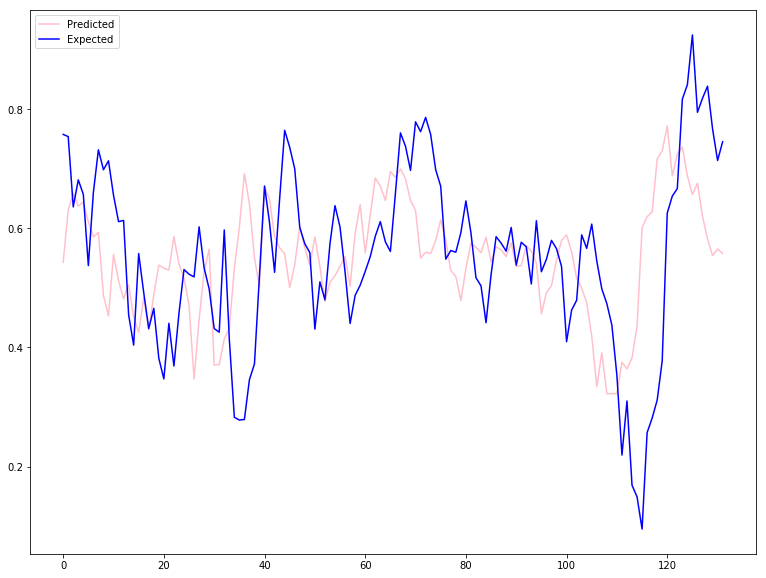

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 25 23:38:11 2018

Following this: 
https://medium.com/@pushkarmandot/build-your-first-deep-
learning-neural-network-model-using-keras-in-python-a90b5864116d

and this:
https://medium.com/mlreview/a-simple-deep-learning-model
-for-stock-price-prediction-using-tensorflow-30505541d877

"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

from keras.models import Sequential
from keras.layers.core import Dense


def adf_test(y):
    '''
    Perform Augmented Dickey Fuller test, for stationarity.
    '''
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)


def model(input_dim):
    '''
    A dense layer is simply a layer where each unit 
    or neuron is connected to each neuron in the next layer.
    Simplest model.
    '''
    model = Sequential()
    
    # Adding the input layer and the first hidden layer
    model.add(Dense(units = 6, kernel_initializer = 'uniform', activation='relu', input_dim=input_dim))
    
    # Adding the 2nd hidden layer
    model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

    # Adding the output layer
    model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    
    # Compiling Neural Network
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['accuracy'])
    
    return model

     
# ------------------ Read and Process Data ------------------ #

# I am replacing outliers instead of dropping for sake of window
df = pd.read_csv("stockdata.csv", index_col='date', parse_dates=['date'])

# Replace signal outliers with last observation
sig_val = df['signal'].value_counts()
criteria = df[ (df['signal'] <= 2) | (df['signal'] >= 400) ]
df['signal'][criteria.index] = np.nan
df['signal'].fillna(method='ffill', inplace=True)

# Replace spy_close_price outliers with last observation.
# Carry last observation forward method (thing in stocks)
sig_val = df['spy_close_price'].value_counts()
criteria = df[ df['spy_close_price'] >= 500 ]
df['spy_close_price'][criteria.index] = np.nan
df['spy_close_price'].fillna(method='ffill', inplace=True)


# ------------- Make Time Series Stationary ------------- #

# sliding window size to simulate 2 weeks ( 10 days )
window=10

# Price and signal diff, make both TS stationary
price_dif = df['spy_close_price'].diff(window).dropna()
sig_dif = df['signal'].diff(window).dropna()

# Data frame with stationary series
df_data = pd.concat([sig_dif, price_dif], axis=1)

# ------------- Preprocessing, Splitting, Scaling ------------- # 

# Dimensions of dataset
n = df_data.shape[0]
p = df_data.shape[1]

# Make data a numpy array
data = df_data.as_matrix()

# Training and Test data, training contains 80% of data.
# We are sequentially slicing. 20% data used for the test.
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end
test_end = n
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

# Scale the data
scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

 # Build x and y
X_train = data_train[:, 0]
y_train = data_train[:, 1]
X_test = data_test[:, 0]
y_test = data_test[:, 1]

# ------------- Neural Network Model ------------- # 

# Build model using simple dense layers
model = model(input_dim=1)

# Train the model
model.fit(
    X_train,
    y_train,
    batch_size=20,
    epochs=500,
    validation_split=0.1,
    verbose=0)

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], sqrt(testScore[0])))

# Predict for X_test
pred = model.predict(X_test)

plt.figure(figsize=(13,10))
plt.plot(pred, color='pink', label='Predicted')
plt.plot(y_test, color='blue', label='Expected')
plt.legend(loc='upper left')
plt.show()


In [ ]:
# lol it's so bad.